In [2]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.layers import Dropout, GRU, Dense, Conv1D, Flatten
from keras.models import Sequential
import matplotlib.pyplot as plt

2024-07-02 09:28:52.664897: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def SMA(data, window_size):
    """
    Calculate the Simple Moving Average (SMA) for the given data.
    
    Parameters:
    data (DataFrame): The input data containing at least the 'Close' column.
    window_size (int): The window size for calculating the SMA.
    
    Returns:
    Series: The SMA values.
    """
    return data['Close'].rolling(window=window_size).mean()

def EMA(data, window_size):
    """
    Calculate the Exponential Moving Average (EMA) for the given data.
    
    Parameters:
    data (DataFrame): The input data containing at least the 'Close' column.
    window_size (int): The window size for calculating the EMA.
    
    Returns:
    Series: The EMA values.
    """
    return data['Close'].ewm(span=window_size).mean()

def MACD(data, short_window, long_window):
    """
    Calculate the Moving Average Convergence Divergence (MACD) for the given data.
    
    Parameters:
    data (DataFrame): The input data containing at least the 'Close' column.
    short_window (int): The window size for the short EMA.
    long_window (int): The window size for the long EMA.
    
    Returns:
    Series: The MACD values.
    """
    short_EMA = EMA(data, short_window)
    long_EMA = EMA(data, long_window)
    return short_EMA - long_EMA

def RSI(data, window_size):
    """
    Calculate the Relative Strength Index (RSI) for the given data.
    
    Parameters:
    data (DataFrame): The input data containing at least the 'Close' column.
    window_size (int): The window size for calculating the RSI.
    
    Returns:
    Series: The RSI values.
    """
    delta = data['Close'].diff()
    delta = delta[1:] 
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ema_up = up.ewm(com=window_size - 1, min_periods=window_size).mean()
    ema_down = down.ewm(com=window_size - 1, min_periods=window_size).mean()
    return ema_up / ema_down

def Bollinger_Bands(data, window_size):
    """
    Calculate the Bollinger Bands for the given data.
    
    Parameters:
    data (DataFrame): The input data containing at least the 'Close' column.
    window_size (int): The window size for calculating the Bollinger Bands.
    
    Returns:
    Tuple[Series, Series]: The upper and lower Bollinger Bands.
    """
    middle_band = SMA(data, window_size)
    std_dev = data['Close'].rolling(window=window_size).std()
    upper_band = middle_band + (std_dev * 2)
    lower_band = middle_band - (std_dev * 2)
    return upper_band, lower_band

def create_sequences(data, seq_length):
    """
    Create sequences of data for time series forecasting.
    
    Parameters:
    data (DataFrame): The input data.
    seq_length (int): The length of each sequence.
    
    Returns:
    Tuple[np.ndarray, np.ndarray]: Arrays of input sequences and corresponding targets.
    """
    xs = []
    ys = []
    
    for i in range(len(data) - seq_length - 1):
        x = data.iloc[i:(i + seq_length)].values
        y = data.iloc[(i + seq_length)]['Close']
        xs.append(x)
        ys.append(y)
        
    return np.array(xs), np.array(ys)

def gain(x):
    """
    Calculate the gain from an array of differences.
    
    Parameters:
    x (np.ndarray): The array of differences.
    
    Returns:
    float: The total gain.
    """
    return ((x > 0) * x).sum()

def loss(x):
    """
    Calculate the loss from an array of differences.
    
    Parameters:
    x (np.ndarray): The array of differences.
    
    Returns:
    float: The total loss.
    """
    return ((x < 0) * x).sum()

def MFI(data, n=14):
    """
    Calculate the Money Flow Index (MFI) for the given data.
    
    Parameters:
    data (DataFrame): The input data containing 'High', 'Low', 'Close', and 'Volume' columns.
    n (int): The window size for calculating the MFI.
    
    Returns:
    np.ndarray: The MFI values.
    """
    high = data['High']
    low = data['Low']
    close = data['Close']
    volume = data['Volume']
    typical_price = (high + low + close) / 3
    money_flow = typical_price * volume
    mf_sign = np.where(typical_price > typical_price.shift(1), 1, -1)
    signed_mf = money_flow * mf_sign
    mf_avg_gain = signed_mf.rolling(n).apply(gain, raw=True)
    mf_avg_loss = signed_mf.rolling(n).apply(loss, raw=True)
    return (100 - (100 / (1 + (mf_avg_gain / abs(mf_avg_loss))))).to_numpy()

def ATR(data, n=14):
    """
    Calculate the Average True Range (ATR) for the given data.
    
    Parameters:
    data (DataFrame): The input data containing 'High', 'Low', and 'Close' columns.
    n (int): The window size for calculating the ATR.
    
    Returns:
    np.ndarray: The ATR values.
    """
    high = data['High']
    low = data['Low']
    close = data['Close']
    tr = np.amax(np.vstack(((high - low).to_numpy(), (abs(high - close)).to_numpy(), (abs(low - close)).to_numpy())).T, axis=1)
    return pd.Series(tr).rolling(n).mean().to_numpy()

def ForceIndex(data, ndays): 
    """
    Calculate the Force Index for the given data.
    
    Parameters:
    data (DataFrame): The input data containing 'Close' and 'Volume' columns.
    ndays (int): The window size for calculating the Force Index.
    
    Returns:
    DataFrame: The data with the Force Index column added.
    """
    FI = pd.Series(data['Close'].diff(ndays) * data['Volume'], name='ForceIndex')
    data = data.join(FI)
    return data

def EMV(data, ndays): 
    """
    Calculate the Ease of Movement (EMV) for the given data.
    
    Parameters:
    data (DataFrame): The input data containing 'High', 'Low', and 'Volume' columns.
    ndays (int): The window size for calculating the EMV.
    
    Returns:
    DataFrame: The data with the EMV column added.
    """
    dm = ((data['High'] + data['Low']) / 2) - ((data['High'].shift(1) + data['Low'].shift(1)) / 2)
    br = (data['Volume'] / 100000000) / (data['High'] - data['Low'])
    EMV = dm / br 
    EMV_MA = pd.Series(EMV.rolling(ndays).mean(), name='EMV')
    data = data.join(EMV_MA)
    return data

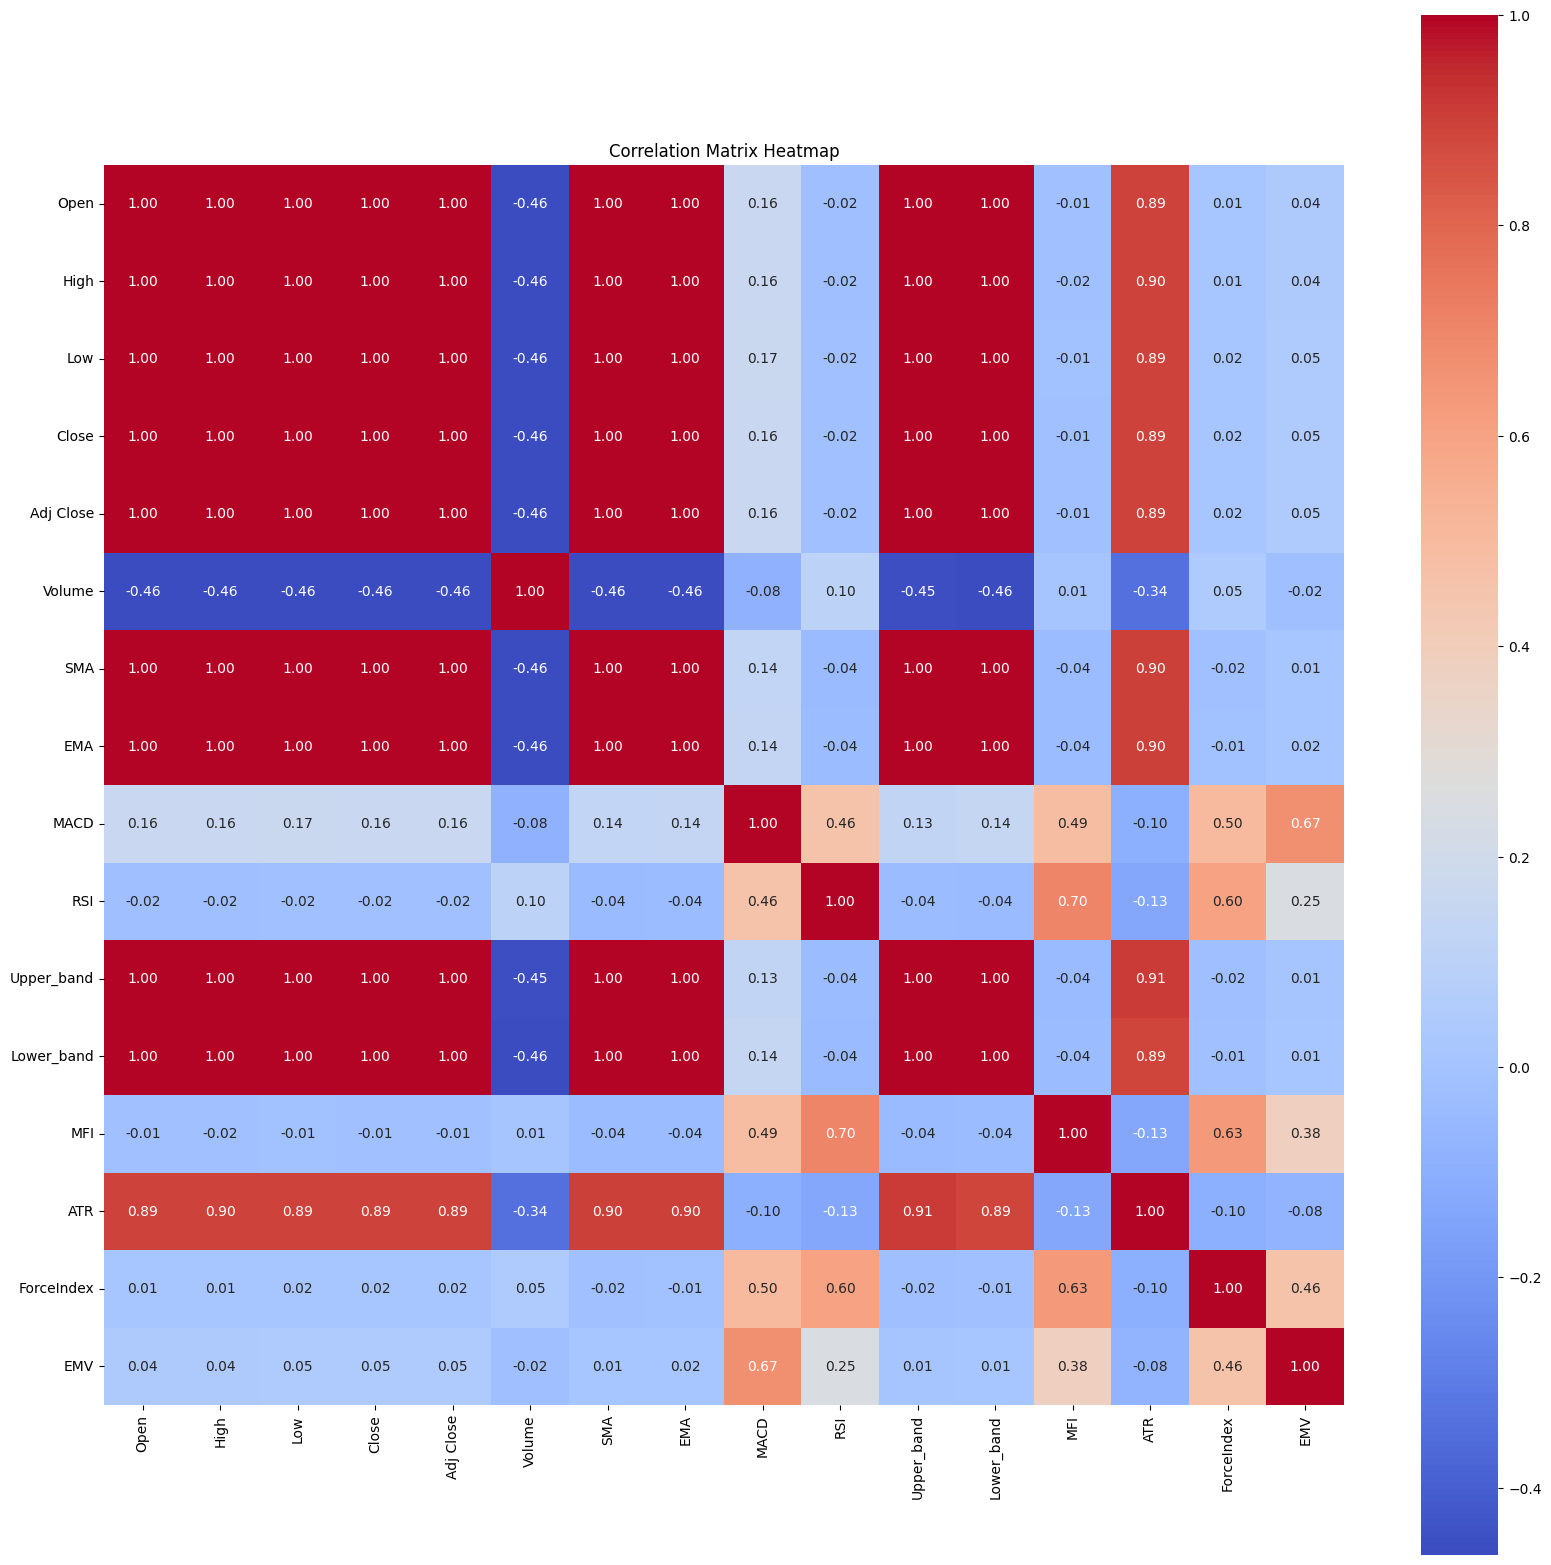

In [4]:
# Load data
data = pd.read_csv('GOOGL_large.csv')

# Use techinical indicators to create new features
data['SMA'] = SMA(data, 14)
data['EMA'] = EMA(data, 14)
data['MACD'] = MACD(data, 12, 26)
data['RSI'] = RSI(data, 14)
data['Upper_band'], data['Lower_band'] = Bollinger_Bands(data, 14)
data['MFI'] = MFI(data, 14)
data['ATR'] = ATR(data, 14)
data['ForceIndex'] = ForceIndex(data, 14)['ForceIndex']
data['EMV'] = EMV(data, 14)['EMV']

# Exploritory Data analysis
corr_matrix = data.corr(numeric_only=True)
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix Heatmap")
plt.show()

# Preprosessing data
data = data.dropna()
columns_to_scale = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'SMA', 'EMA', 'MACD', 'RSI', 'ATR', 'ForceIndex', 'EMV', 'Upper_band', 'Lower_band']
scaler = MinMaxScaler()
data_scaled = data.copy()
data_scaled[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])
X, y = create_sequences(data_scaled, 10)
features = data_scaled.columns.drop(['Close', 'Date', 'MFI', 'RSI', 'Volume']) # Drop negatively correlated features and the Date and Close columns
X = data_scaled[features]
y = data_scaled['Close']
X = np.array(X)
y = np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [5]:
# Create train LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=50, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units=25))
lstm_model.add(Dense(units=1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['root_mean_squared_error'])
lstm_model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100


/Users/School/Documents/Github/ML_StockPriceForcasting/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0224 - root_mean_squared_error: 0.1394
Epoch 2/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0015 - root_mean_squared_error: 0.0384
Epoch 3/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0010 - root_mean_squared_error: 0.0318
Epoch 4/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.9310e-04 - root_mean_squared_error: 0.0299
Epoch 5/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.0532e-04 - root_mean_squared_error: 0.0283
Epoch 6/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.2922e-04 - root_mean_squared_error: 0.0288
Epoch 7/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.5501e-04 - root_mean_squared_error: 0.0256
Epoch 8/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.4451e-04 - root_mean_squared_error: 0.0253
Epoch 9/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.9271e-04 - root_mean_squared_error: 0.0243
Epoch 10/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.9325e-

In [6]:
# Define GRU model
gru_model = Sequential()
gru_model.add(GRU(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
gru_model.add(GRU(50, return_sequences=False))
gru_model.add(Dense(25))
gru_model.add(Dense(1))

# Compile and fit GRU model
gru_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['root_mean_squared_error'])
gru_model.fit(X_train, y_train, batch_size=64, epochs=100)

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0612 - root_mean_squared_error: 0.2386
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.5593e-04 - root_mean_squared_error: 0.0235
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.0276e-04 - root_mean_squared_error: 0.0174
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.7088e-04 - root_mean_squared_error: 0.0164
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.2955e-04 - root_mean_squared_error: 0.0151
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.9055e-04 - root_mean_squared_error: 0.0138
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.9316e-04 - root_mean_squared_error: 0.0139
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.6695e-04 - root_mean_squared_error: 0.0129
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.4470e-04 - root_mean_squared_error: 0.0120
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss

In [7]:
# Define 1D CNN model
cnn_model = Sequential()
cnn_model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
cnn_model.add(Flatten())
cnn_model.add(Dense(50, activation='relu'))
cnn_model.add(Dense(1))

# Compile and fit 1D CNN model
cnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['root_mean_squared_error'])
cnn_model.fit(X_train, y_train, batch_size=64, epochs=100)

Epoch 1/100


/Users/School/Documents/Github/ML_StockPriceForcasting/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0182 - root_mean_squared_error: 0.1235
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8239e-05 - root_mean_squared_error: 0.0082
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4840e-05 - root_mean_squared_error: 0.0067
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2143e-05 - root_mean_squared_error: 0.0065
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8780e-05 - root_mean_squared_error: 0.0062
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7563e-05 - root_mean_squared_error: 0.0061
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1710e-05 - root_mean_squared_error: 0.0056
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.6413e-05 - root_mean_squared_error: 0.0051
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9058e-05 - root_mean_squared_error: 0.0054
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5875e-05 - root_me

In [8]:
# Print test loss
score = lstm_model.evaluate(X_test, y_test, verbose=0)
gru_score = gru_model.evaluate(X_test, y_test, verbose=0)
cnn_score = cnn_model.evaluate(X_test, y_test, verbose=0)
print('Test Loss (MSE):', score[0])
print('Test Root Mean Squared Error:', score[1])
print('GRU Test Loss (MSE):', gru_score[0])
print('GRU Test Root Mean Squared Error:', gru_score[1])
print('CNN Test Loss (MSE):', cnn_score[0])
print('CNN Test Root Mean Squared Error:', cnn_score[1])

# Ensemble Method: Averaging
pred_lstm = lstm_model.predict(X_test)
pred_gru = gru_model.predict(X_test)
pred_cnn = cnn_model.predict(X_test)
pred = (pred_lstm + pred_gru + pred_cnn) / 3

# Calculate and print MAE and RMSE for Ensemble
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
print('Mean Absolute Error:', mae)
print('Root Mean Squared Error:', rmse)

Test Loss (MSE): 0.0002629927475936711
Test Root Mean Squared Error: 0.016217051073908806
GRU Test Loss (MSE): 5.669276288244873e-05
GRU Test Root Mean Squared Error: 0.007529459893703461
CNN Test Loss (MSE): 8.129536013257166e-07
CNN Test Root Mean Squared Error: 0.0009016394033096731
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Absolute Error: 0.003920219558576435
Root Mean Squared Error: 0.005868336063252316
